In [11]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import sys
import importlib
import random 
import pandas as pd
pd.options.mode.copy_on_write = True
import time
from os.path import join as pjoin
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch 

In [33]:
################## IMPORT MY MODULES ##################
sys.path.append('../src')

import helpers as hlp
import evaluation
import dataset as ds
import trainer
import models

sys.path.append('../baseline/fins')

import model_fins
import audio_fins

importlib.reload(evaluation)
importlib.reload(hlp)
importlib.reload(ds)
importlib.reload(trainer)
importlib.reload(models)
importlib.reload(model_fins)

<module 'model_fins' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../baseline/fins/model_fins.py'>

In [25]:
################## LOAD FINS TRAINING RESULTS AND CONFIG  ##################

fins_project_path="/home/ubuntu/joanna/fins/fins"
fins_checkpoints_path="/home/ubuntu/Data/RESULTS-VAE-IR/fins/checkpoints/m-240416-111748"

# load fins config
fins_config_path = pjoin(fins_project_path,"config.yaml")
fins_config = hlp.load_config_fins(fins_config_path)

# load fins model
model = model_fins.FilteredNoiseShaper(fins_config.model.params).to("cuda")

state_dicts = torch.load(pjoin(fins_checkpoints_path,"epoch-122.pt"), map_location="cuda")
model.load_state_dict(state_dicts["model_state_dict"])
model.eval()

FilteredNoiseShaper(
  (encoder): Encoder(
    (encode): Sequential(
      (0): EncoderBlock(
        (conv): Sequential(
          (0): Conv1d(1, 32, kernel_size=(15,), stride=(2,), padding=(7,))
          (1): PReLU(num_parameters=1)
        )
        (skip_conv): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(2,))
        )
      )
      (1): EncoderBlock(
        (conv): Sequential(
          (0): Conv1d(32, 32, kernel_size=(15,), stride=(2,), padding=(7,))
          (1): PReLU(num_parameters=1)
        )
        (skip_conv): Sequential(
          (0): Conv1d(32, 32, kernel_size=(1,), stride=(2,))
        )
      )
      (2): EncoderBlock(
        (conv): Sequential(
          (0): Conv1d(32, 64, kernel_size=(15,), stride=(2,), padding=(7,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=1)
        )
        (skip_conv): Sequential(
          (0): Conv1d(32, 64, kernel_size=(1,),

In [80]:
################## LOAD OUR DATASET  ##################

config=hlp.load_config("../config/basic.yaml")

# instantiate a test data set 
config["split"]="test"
config["df_metadata"]="/home/ubuntu/joanna/reverb-match-cond-u-net/dataset-metadata/nonoise_48khz_guestxr.csv"
config["p_noise"]=0
dataset=ds.DatasetReverbTransfer(config)
# get one data sample 
sContent, sStyle, sTarget, sAnecho = dataset[128]


In [81]:
# Model forward

# Noise for late part
rir_length = int(fins_config.model.params.rir_duration * fins_config.model.params.sr)
stochastic_noise = torch.randn((1, 1, rir_length), device="cuda")
batch_stochastic_noise = stochastic_noise.repeat(1, fins_config.model.params.num_filters, 1)
# Noise for decoder conditioning
batch_noise_condition = torch.randn((1, fins_config.model.params.noise_condition_length), device="cuda")
reverberated_source=sStyle.unsqueeze(0).to("cuda")
reverberated_source = audio_fins.audio_normalize_batch(reverberated_source, "rms", fins_config.model.params.rms_level)
predicted_rir = model(reverberated_source, batch_stochastic_noise, batch_noise_condition)

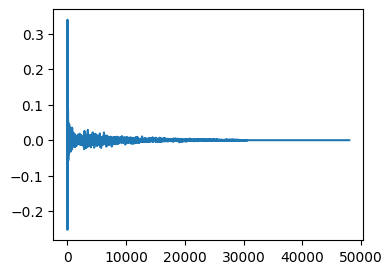

In [82]:
plt.figure()
plt.plot(predicted_rir.squeeze(0).detach().cpu().T)
plt.show()


In [83]:

sPredictionFins1=sig.fftconvolve(sAnecho, predicted_rir.squeeze(0).detach().cpu(),mode="full")


In [84]:
# playback for the data sample
audios=[sAnecho, sStyle, sPredictionFins1, sTarget]
names=["sAnecho","sStyle","sPredictionFins1", "sTarget"]

for i,audio in enumerate(audios):
    print(names[i])
    audio=audio.squeeze(0)
    display(Audio(audio,rate=48e3))

sAnecho


sStyle


sPredictionFins1


sTarget
